# Facial Emotion Detection Model Training

## 📋 Before Running This Notebook:

### Step 1: Download Dataset
1. Go to: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
2. Download the dataset (you may need to sign in to Kaggle)
3. Extract the ZIP file to your computer
4. Note the path where you extracted it

### Step 2: Update Dataset Path
- In the next cell, update `data_dir` to point to your extracted dataset's `images` folder
- Example: `C:/Users/YourName/Downloads/face-expression-recognition-dataset/images`

### Step 3: Run All Cells
- This will train the model (takes 30-60 minutes depending on your hardware)
- The trained model will be saved as `emotion_detection.h5`

### Step 4: Copy Model to Backend
- After training, copy `emotion_detection.h5` to the `backend` folder
- Then restart your Flask server

---

Let's get started! 🚀

In [5]:
# Basic Imports 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Keras Imports 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# sklearn imports
from sklearn.metrics import classification_report, confusion_matrix


In [6]:
# Check GPU availability (Your MX450 should be detected)
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("\n🔍 Checking GPU availability...")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {len(gpus)} GPU(s) available!")
    for gpu in gpus:
        print(f"   - {gpu}")
    
    # Configure GPU memory growth to avoid OOM errors
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(f"⚠️ Memory growth setting error: {e}")
else:
    print("⚠️ No GPU detected - Training will use CPU (slower)")
    print("   Make sure NVIDIA drivers and CUDA are installed for MX450")

print("\n🚀 Ready to train!")

TensorFlow version: 2.20.0

🔍 Checking GPU availability...
⚠️ No GPU detected - Training will use CPU (slower)
   Make sure NVIDIA drivers and CUDA are installed for MX450

🚀 Ready to train!


In [7]:
# Dataset Path - Updated for your local setup
data_dir = 'images'  # Your dataset is in the images folder!

train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

# Verify paths exist
if not os.path.exists(data_dir):
    print(f"❌ ERROR: Dataset not found at: {data_dir}")
    print("Please download the dataset and update the path above!")
else:
    print(f"✅ Dataset found!")
    print(f"Train folder: {train_dir}")
    print(f"Validation folder: {validation_dir}")
    
    # Count images
    if os.path.exists(train_dir):
        train_emotions = os.listdir(train_dir)
        print(f"\n📊 Training emotions: {train_emotions}")
    if os.path.exists(validation_dir):
        val_emotions = os.listdir(validation_dir)
        print(f"📊 Validation emotions: {val_emotions}")

✅ Dataset found!
Train folder: images\train
Validation folder: images\validation

📊 Training emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
📊 Validation emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [8]:
# Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=20,
    zoom_range=0.2, 
    horizontal_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)


validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


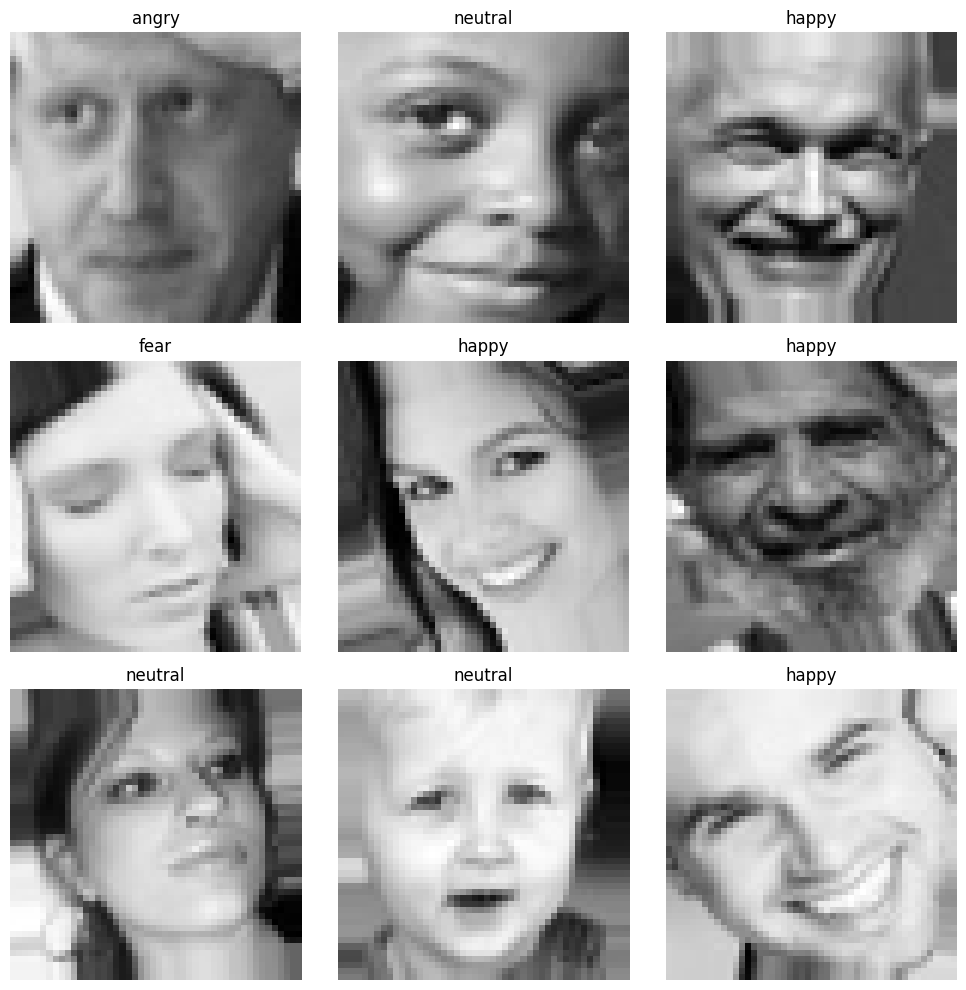

In [ ]:
class_names = list(train_generator.class_indices.keys())

images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].reshape(48, 48), cmap='gray')
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# 3. CNN Model Architecture
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\prave\OneDrive\Desktop\Face detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,474,759 (9.44 MB)

 Trainable params: 2,472,839 (9.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [10]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Model Training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler]
)

Num GPUs Available: 0
Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 134s 291ms/step - accuracy: 0.2891 - loss: 2.0745 - val_accuracy: 0.2995 - val_loss: 1.7578 - learning_rate: 0.0010
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 134s 291ms/step - accuracy: 0.2891 - loss: 2.0745 - val_accuracy: 0.2995 - val_loss: 1.7578 - learning_rate: 0.0010
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 173s 384ms/step - accuracy: 0.3926 - loss: 1.6053 - val_accuracy: 0.4239 - val_loss: 1.5644 - learning_rate: 0.0010
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 173s 384ms/step - accuracy: 0.3926 - loss: 1.6053 - val_accuracy: 0.4239 - val_loss: 1.5644 - learning_rate: 0.0010
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 206s 393ms/step - accuracy: 0.4342 - loss: 1.4729 - val_accuracy: 0.4130 - val_loss: 1.5635 - learning_rate: 0.0010
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 206s 393ms/step - accuracy: 0.4342 - loss: 1.4729 - val_accuracy: 0.4130 - val_loss: 1.5635 - learning_rate: 0.0010
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 17

In [ ]:
# 6. Evaluation - Classification Report & Confusion Matrix
val_images, val_labels = next(validation_generator)
predictions = model.predict(val_images)
y_true = np.argmax(val_labels, axis=1)
y_pred = np.argmax(predictions, axis=1)

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def detect_emotion(image_path):
    img = image.load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class = class_names[predicted_index]
    confidence = round(prediction[0][predicted_index] * 100, 2)  # Confidence in %

    # Display the image with the predicted label and confidence
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Emotion: {predicted_class} ({confidence}%)')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence


In [ ]:
# Example Detection
print(detect_emotion('/kaggle/input/face-expression-recognition-dataset/images/train/happy/10005.jpg'))

In [ ]:
# Example Detection
print(detect_emotion('/kaggle/input/face-expression-recognition-dataset/images/train/surprise/10249.jpg'))

In [11]:
# 8. Save Model
model.save('emotion_detection.h5')
print("✅ Model saved as 'emotion_detection.h5'")

✅ Model saved as 'emotion_detection.h5'


In [12]:
# 9. Copy Model to Backend Folder (Automatic)
import shutil

backend_path = os.path.join(os.path.dirname(os.getcwd()), 'backend', 'emotion_detection.h5')
current_model = 'emotion_detection.h5'

try:
    # Try to copy to backend folder
    if os.path.exists('backend'):
        shutil.copy(current_model, 'backend/emotion_detection.h5')
        print("✅ Model copied to backend folder!")
    else:
        print("⚠️ Backend folder not found in current directory")
        print(f"Please manually copy 'emotion_detection.h5' to your backend folder")
except Exception as e:
    print(f"⚠️ Could not auto-copy: {e}")
    print("Please manually copy 'emotion_detection.h5' to the backend folder")

print("\n🎉 Training Complete!")
print("Next steps:")
print("1. If auto-copy failed, manually copy 'emotion_detection.h5' to the backend folder")
print("2. Restart your Flask server (if running)")
print("3. Open frontend/index.html in your browser")
print("4. Click 'Start Camera' and test emotion detection!")

✅ Model copied to backend folder!

🎉 Training Complete!
Next steps:
1. If auto-copy failed, manually copy 'emotion_detection.h5' to the backend folder
2. Restart your Flask server (if running)
3. Open frontend/index.html in your browser
4. Click 'Start Camera' and test emotion detection!
